In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

sys.path.insert(1, '..\\..\\Instruments\\network\\RS_Signal_Generator')
sys.path.insert(2, '..\\..\\Instruments\\Acquisition_Card')
sys.path.insert(3, '..\\..\\Instruments\\QuickSyn')
sys.path.insert(4, '..\\')

import Tuls as Ts
import RS_SMA100B
import FSL_0010
from Card_Class import PXIe5170R
import Config as par

In [3]:
QSyn_port       = 'COM35'
SG_ip           = '192.168.40.15'                                  
Card_Name       = 'PXI1Slot3'

fsl             = FSL_0010.FSL10_synthesizer(device_address = QSyn_port)
sGen            = RS_SMA100B.SMA100B(ip = SG_ip)
pxie            = PXIe5170R(resource_name = Card_Name)

FSL_0010:	Connection successful!
SMA100B:	Connection successful!
PXIe_5170R:	Connection successful!


In [6]:
# Quick Syn
LO =  5e9
fsl_freq = round(LO, 1)
 

# MR GEN
dwc_f = 10e6                                                        # Down conversion frequency
step = 10e6
n = 20                                                              # number of steps

pulse_f_min     = LO + dwc_f
pulse_f_max		= pulse_f_min + n * step

amp_i			= -30                                               # dBm
amp_f           = -10
 
pulse_period    = 4e-6                                              # 4e-6 con 250e6 dà 1000 punti
pulse_delay     = 0
percent         = 5
pulse_width     = pulse_period * (1 - percent/100)                  # min 20ns


# PXIE
sample_rate     = 250e6                                             # Maximum Value: 250.0e6
num_pts         = int(sample_rate * pulse_period)                   # min 5ns                             
channels = {'0': 'I', 
			'1': 'Q',
			'2': None,
			'3': 'trigger'}


sGen.pul_gen_mode('SING')
sGen.pul_trig_mode('SING')
sGen.pul_gen_params(delay = pulse_delay, 
                    width = pulse_width, 
                    period = pulse_period) 


# Parameters for the Acquisition Card
pxie.coupling           = 'AC'
pxie.num_pts            = num_pts
pxie.num_records        = 1
pxie.sample_rate        = sample_rate                               # Maximum Value: 250.0e6


# FSL-0010
print(fsl.set_frequency(LO))

FSL_0010: Frequency set to 5.0 GHz.


FSL_0010: Frequency set to 1.0 GHz.
AcquisitionStatus.COMPLETE


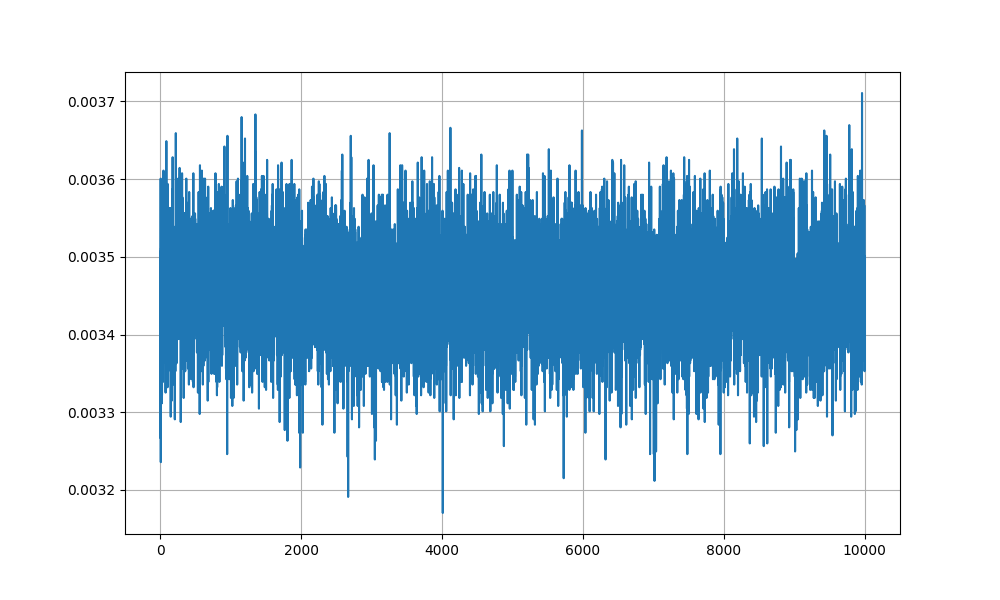

In [10]:
pxie.num_pts            = 10000
pxie.sample_rate        = 250e6 
pxie.num_records        = 100

sGen.pul_gen_mode('SING')
sGen.pul_trig_mode('AUTO')
print(fsl.set_frequency(1e9))
sGen.pul_state(1)
sGen.RF_freq(1e9)
sGen.RF_lvl_ampl(-15)
sGen.RF_state(1)

pxie.coupling = 'AC'
pxie.voltage_range = 3
pxie.open(trigger_channel = 3)
waveforms = pxie.acquisition(sGen.pul_exe_sing_trig)

I = np.mean(waveforms['CH0'], axis=0)
# mod = 5*np.log10(Q**2 + I**2)



plt.figure(figsize=(10,6))
plt.grid()
plt.plot(I)
plt.show()

In [8]:
channels = {'0': 'I', 
			'1': None,
			'2': None,
			'3': 'trigger'}

print(fsl.set_frequency(LO))
print(fsl.set_output('ON'))
pxie.open(trigger_channel = '3')

f_range = np.arange(LO+10e6, LO+30e6, 10e6) #1e6)
f_dict = Ts.fetch_freq_range(	f_range 	= f_range, 
								I_ch 		= 0,
								Q_ch		= 1,
								LO 			= LO,
								SG_Class 	= sGen,
								pxie_Class 	= pxie
								)

print(fsl.set_output('OFF'))

# HDF5 SAVING
filename = f'TEST.h5'
if os.path.exists(filename):
  os.remove(filename)
Ts.save_dict_to_hdf5(f_dict, filename)

FSL_0010: Frequency set to 5.0 GHz.
RF set to ON
f0	: 0 %

KeyError: 0

In [ ]:
# data = load_hdf5_to_dict('Mixer_1237_9.5GHz.h5')

# # wave = np.array(data['freqs']['f05']['Q'])
# # wave_I = np.array(data['freqs']['f05']['I'])

# wave_Q = Ts.find_key(data, 'Q')
# wave_I = Ts.find_key(data, 'I')

# #print(I)
# a = (Ts.get_avg_power(wave_Q)['mean'])*1e3
# b = Ts.dBm_to_mVpk(data['power_(dBm)'])

# print(a)
# print(b)
# print((Ts.get_avg_power(wave_I, False)['mean'])*1e3)

# print('Attenuazione su Q: ', (1 - a/b) )

In [ ]:
# def fetch_freq_range(f_range, CHs, SG_Class):
# 	counter = 1
# 	digits_f = "{:0"+str(len(str(len(f_range))))+"d}"
# 	f_dict = {  'RF_input_Hz':  {},
# 				'LO_input_Hz':  LO}
# 	for i, f in enumerate(f_range):
# 		print(f'\rf{digits_f.format(i)}	: {int(counter*100/len(f_range))} %', end='', flush = True)
# 		counter += 1
# 		# Signal Generator config.
# 		# SG_Class.RF_freq(f_range) 
# 		# SG_Class.pul_state(1)
# 		# SG_Class.RF_state(1)
# 		# waveforms = pxie.acquisition(SG_Class.pul_exe_sing_trig)
# 		# SG_Class.pul_state(0)
# 		# SG_Class.RF_state(0)
# 		x = np.linspace(0, 100, 100)
# 		waveforms = [np.sin(x),np.cos(x)]

		
# 		dict = {}
# 		for key, value in CHs.items():
# 			if value == 'I' or value == 'Q':
# 				# dict[value] = np.array(waveforms[int(key)].samples.tolist())
# 				dict[value] = waveforms[int(key)]
# 				FT = np.abs(np.fft.fft(dict[value]))
# 				N = len(dict[value])
# 				freqs = np.fft.fftfreq(N,1/sample_rate) 
# 				dict['f_'+value+'_Hz'] = freqs[np.argmax(FT[:N // 2])]
# 				dict['p_'+value+'_mV'] = Tools.get_avg_power(y = dict[value], toggle_plot = False, sample_rate = sample_rate)['mean']*1e3
# 		f_dict['RF_input_Hz'][f'f{digits_f.format(i)}'] = dict
		
# 	return f_dict